In [10]:
import sys, os
sys.path.append(os.path.join(sys.path[0].split('Documents')[0],'Documents/BecaNLP/Utils'))

import NLPUtils as nlp
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cargamos el dataset

,Pregunta,Intencion
0,como puedo trabajar en santander rio,102
1,pagar tarjeta visa querer reintegro,350
2,pagar tarjeta naranja sistema,132
3,no se debitó la primera cuota del plan de bien...,129
4,abonar tarjeta credito,342


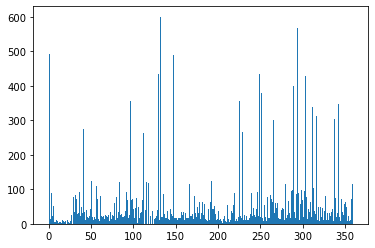

In [11]:
df = pd.read_csv('../train.csv',sep = '|')
df['Intencion'] = df.Intencion.str.findall(r'\d+').apply(lambda x: int(x[0]))
categories = set(df['Intencion'].values)
name2idx = {name:idx for idx, name in enumerate(categories)}
idx2name = {idx:name for idx, name in enumerate(categories)}
_ = plt.hist(df['Intencion'].values,bins=max(df['Intencion']))
df.head()

# Intentamos con BERT otra vez

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from utils import *

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS list all trans world airline flights from indianapolis to houston that arrive in houston between 1030 am and 1130 am EOS
Query vector:  [178 549 207 863 930 199 429 444 489 851 476 826 236 482 476 259  17 210
 215  29 210 179]
Intent label:  flight
Slot text:  O O O B-airline_name I-airline_name I-airline_name O O B-fromloc.city_name O B-toloc.city_name O O O B-toloc.city_name O B-arrive_time.start_time I-arrive_time.start_time O B-arrive_time.end_time I-arrive_time.end_time O
Slot vector:  [128, 128, 128, 2, 83, 83, 128, 128, 48, 128, 78, 128, 128, 128, 78, 128, 13, 88, 128, 10, 86, 128]
**************************************************************************
Query text: BOS i 'm looking for flights from oakland to atlanta leaving before 1045 am EOS
Query vector:  [178 479   3 562 435 429 444 644 851 242 539 253  19 210 179]
Intent label:  flight
Slot text

In [14]:
# Preprocesamos las muestras
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenizamos las oraciones
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

 
MAX_LEN = 128 # Máxima longitud de las secuencias

# Paddeamos y convertimos en idx:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]
Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


array([  101,  1045,  2215,  2000,  4875,  2013,  3731,  2012,  6640,
        2620,  2572,  1998,  7180,  1999,  7573,  2012, 11118,  2692,
        1999,  1996,  2851,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [15]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [16]:
# Use train_test_split to split our data into train and validation sets for training
# name2idx = {name:idx for idx, name in enumerate(np.unique(intent_data_label_train))}
# idx2name = {idx:name for idx, name in enumerate(np.unique(intent_data_label_train))}
# labels = np.array([name2idx[name] for name in intent_data_label_train])
labels = intent_data_label_train

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=labels.max()+1)#int(np.unique(labels).size))
USE_GPU = True
device = torch.device('cuda:1') if torch.cuda.is_available() and USE_GPU else torch.device('cpu')
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.057765837333032


Epoch:  25%|██▌       | 1/4 [00:47<02:21, 47.32s/it]

Validation Accuracy: 0.9691840277777778
Train loss: 0.15069342963397503


Epoch:  50%|█████     | 2/4 [01:34<01:34, 47.30s/it]

Validation Accuracy: 0.990234375
Train loss: 0.06278503004993712


Epoch:  75%|███████▌  | 3/4 [02:21<00:47, 47.24s/it]

Validation Accuracy: 0.9867621527777778
Train loss: 0.03930572856749807


Epoch: 100%|██████████| 4/4 [03:08<00:00, 47.22s/it]

Validation Accuracy: 0.994140625


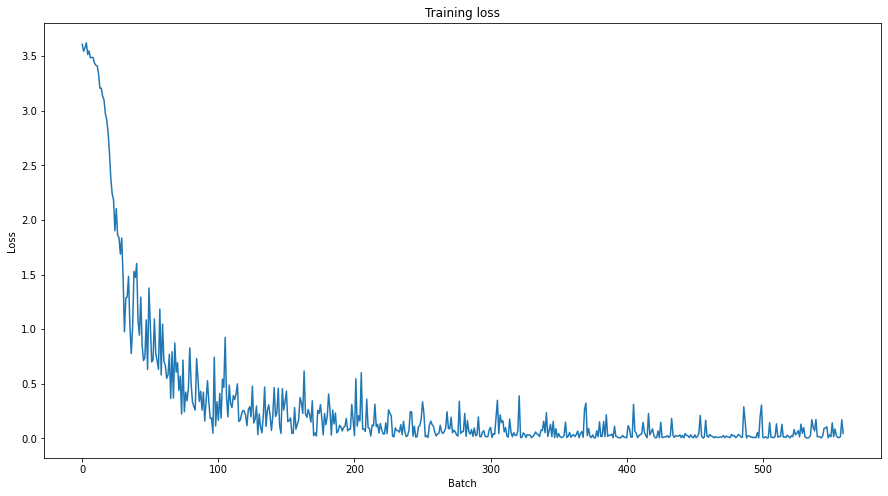

In [18]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

lr = 2e-5
max_grad_norm = 1.0
num_training_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_training_steps)  # 0.1
optimizer = AdamW(optimizer_grouped_parameters,lr=lr,correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=num_training_steps)  # PyTorch scheduler

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
train_loss_set = [] # Store our loss and accuracy for plotting
epochs = 4 # Number of training epochs 

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
    
    ## TRAINING:
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss, _ = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
        optimizer.step()
        scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    ## VALIDATION:
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()